In [35]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

## Download Food-5k dataset

https://www.kaggle.com/binhminhs10/food5k/downloads/food5k.zip

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## Settings

In [17]:
DATASET_PATH = '/content/gdrive/My Drive/Datasets/Food-5K/'
DATASET_PATH = 'Food-5K/Food-5K/'

In [25]:
!cp Food-5K/Food-5K/training/0*.jpg data/train/nonfood
!cp Food-5K/Food-5K/training/1*.jpg data/train/food
!cp Food-5K/Food-5K/evaluation/0*.jpg data/test/nonfood
!cp Food-5K/Food-5K/evaluation/1*.jpg data/test/food
!cp Food-5K/Food-5K/validation/0*.jpg data/val/nonfood
!cp Food-5K/Food-5K/validation/1*.jpg data/val/food

In [11]:
!ls "$DATASET_PATH"

evaluation training   validation


In [37]:
training_dir = 'data/train/'
valid_dir = 'data/val/'
test_dir = 'data/test/'

img_width, img_height = 256, 256
batch_size = 32
epochs = 50

## Data Generators

In [85]:
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
                        training_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary'
)


valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

valid_generator = valid_datagen.flow_from_directory(
                        valid_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_generator = valid_datagen.flow_from_directory(
                        test_dir,
                        target_size = (img_height, img_width),
                        batch_size = 16, 
                        class_mode = 'binary')

Found 3002 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [86]:
valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

valid_generator = valid_datagen.flow_from_directory(
                        valid_dir,
                        target_size = (img_height, img_width),
                        batch_size = batch_size, 
                        class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_generator = valid_datagen.flow_from_directory(
                        test_dir,
                        target_size = (img_height, img_width),
                        batch_size = 16, 
                        class_mode = 'binary')

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [87]:
import numpy as np

In [88]:
np.unique(train_generator.classes)

array([0, 1], dtype=int32)

In [89]:
imgs, labels = next(train_generator)


In [90]:
imgs.shape

(32, 256, 256, 3)

In [91]:
labels

array([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

## Image samples

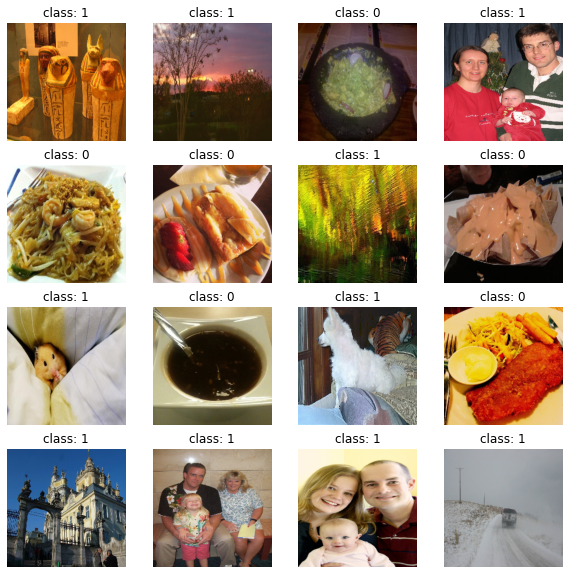

In [92]:

num_figs = 16

fig, axs = plt.subplots(num_figs // 4, 4, figsize=(10,10))
for i in range(num_figs):
    axs[i // 4, i % 4].imshow(imgs[i])
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f'class: {int(labels[i])}')

## Load VGG model

In [93]:
model = applications.VGG16(weights = "imagenet",
                           include_top = False,
                           input_shape = (img_width, img_height, 3))

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

## Freeze layers

In [94]:
model.layers

In [95]:
for layer in model.layers:
    layer.trainable = False

## Add custom layers

In [96]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs = model.input, outputs = output)

In [97]:
512 * 512

262144

In [98]:
model_final.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [101]:
# creating the final model 


# compile the model 
model_final.compile(loss = "binary_crossentropy", 
                    optimizer = optimizers.Adam(lr=0.001), 
                    metrics=["accuracy"])

model_final.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

/Users/julian/opt/anaconda3/envs/pef/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Model Fit

In [102]:
# Save the model according to the conditions  
checkpoint_file = "vgg16_1.h5"

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_acc', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')


# Train the model 
hist = model_final.fit(train_generator,
                        steps_per_epoch = train_generator.n // batch_size,
                        epochs = epochs,
                        validation_data = valid_generator,
                        validation_steps = valid_generator.n // batch_size,
                        callbacks = [checkpoint, early],
                        verbose = 1)

Epoch 1/50
93/93 [==============================] - 510s 6s/step - loss: 0.3402 - accuracy: 0.8529 - val_loss: 0.1816 - val_accuracy: 0.9335
Epoch 2/50
93/93 [==============================] - 674s 7s/step - loss: 0.1973 - accuracy: 0.9266 - val_loss: 0.1749 - val_accuracy: 0.9385
Epoch 3/50
93/93 [==============================] - 636s 7s/step - loss: 0.1586 - accuracy: 0.9357 - val_loss: 0.1313 - val_accuracy: 0.9526
Epoch 4/50
93/93 [==============================] - 656s 7s/step - loss: 0.1501 - accuracy: 0.9411 - val_loss: 0.1167 - val_accuracy: 0.9567
Epoch 5/50
93/93 [==============================] - 591s 6s/step - loss: 0.1263 - accuracy: 0.9495 - val_loss: 0.1170 - val_accuracy: 0.9597
Epoch 6/50
93/93 [==============================] - 551s 6s/step - loss: 0.1227 - accuracy: 0.9539 - val_loss: 0.1085 - val_accuracy: 0.9617
Epoch 7/50
93/93 [==============================] - 656s 7s/step - loss: 0.1157 - accuracy: 0.9566 - val_loss: 0.1100 - val_accuracy: 0.9567
Epoch 8/50
93

In [105]:
# hist.history

<ipython-input-107-69bb7b904950>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


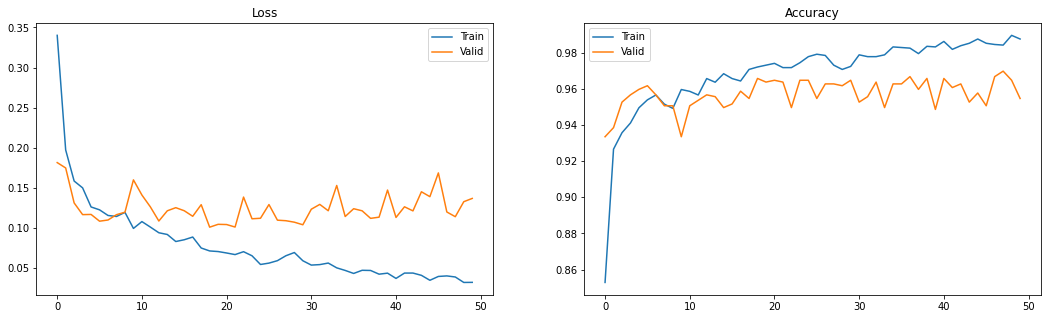

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(18,5))

axs[0].plot(hist.history['loss'], label='Train')
axs[0].plot(hist.history['val_loss'], label='Valid')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(hist.history['accuracy'], label='Train')
axs[1].plot(hist.history['val_accuracy'], label='Valid')
axs[1].set_title('Accuracy')
axs[1].legend()
fig.show()

In [109]:
checkpoint_file

'vgg16_1.h5'

In [110]:
# model_final.load_weights(checkpoint_file)

loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)
print(f'Test Acc: {acc}')

<ipython-input-110-0b704a9e9170>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)


Test Acc: 0.944556474685669


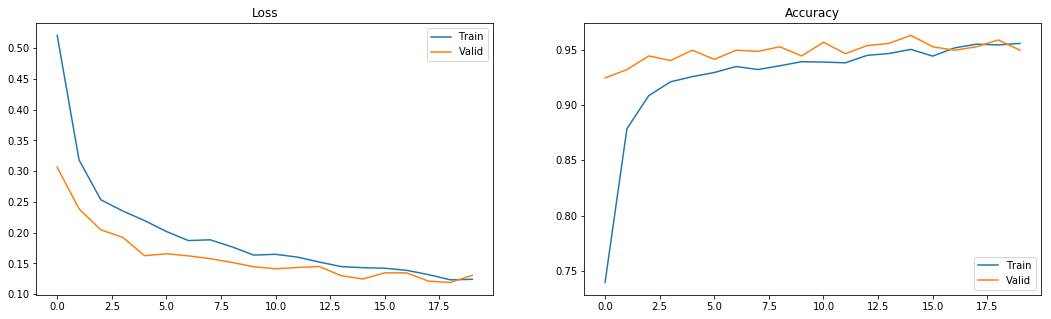

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(18,5))

axs[0].plot(hist.history['loss'], label='Train')
axs[0].plot(hist.history['val_loss'], label='Valid')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(hist.history['acc'], label='Train')
axs[1].plot(hist.history['val_acc'], label='Valid')
axs[1].set_title('Accuracy')
axs[1].legend()
fig.show()

In [43]:
model_final.load_weights(checkpoint_file)

loss, acc = model_final.evaluate_generator(test_generator, steps = test_generator.n // test_generator.batch_size)
print(f'Test Acc: {acc}')

Test Acc: 0.9465725806451613
